In [25]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available. PyTorch is using CPU.")

PyTorch version: 2.6.0+cu126
Torchvision version: 0.21.0+cu126
CUDA is available. PyTorch is using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [1]:
from models import CNN_Model, LSTM_Model, BiLSTM_Model, rule_fall_detection, Rule_Model

print(LSTM_Model)

<class 'models.LSTM_Model'>


In [2]:
import numpy as np
import json
import os
import csv
import pandas as pd

ur_path = 'csv_data/ur_keypoints_yolo.csv'

def read_data(path):
  video_data = []
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      video_data.append(row)
  return video_data

ur_data = read_data(ur_path)

# not normalize yet
print(ur_data[15])

['213.86915588378906', '66.06787872314453', '245.36093139648438', '160.8792724609375', '228.40293884277344', '76.34473419189453', '0.9424185752868652', '230.2623748779297', '74.17759704589844', '0.9156703352928162', '226.6461181640625', '74.50898742675781', '0.782278835773468', '234.19691467285156', '75.8281021118164', '0.825977623462677', '0.0', '0.0', '0.38768282532691956', '239.1170654296875', '88.71800994873047', '0.9914864301681519', '224.50448608398438', '89.87483215332031', '0.9615622758865356', '243.29200744628906', '104.1490707397461', '0.9646899104118347', '222.00782775878906', '105.09140014648438', '0.7674667239189148', '238.1511993408203', '119.3595199584961', '0.9240130186080933', '221.8865203857422', '119.2650146484375', '0.713083803653717', '236.1707305908203', '120.35301208496094', '0.9916566610336304', '226.21937561035156', '120.42048645019531', '0.9806389212608337', '236.69302368164062', '142.2818603515625', '0.9722954034805298', '223.82164001464844', '142.39659118652

In [3]:
# normalize data according to the size of videos in different dataset
def normalize(list, width, height, offset):
  for record in list:
    for i in range(offset, 51 + offset, 3): # 17 keypoints, each keypoint is x, y and confidence
        record[i] = float(record[i]) / width
        record[i + 1] = float(record[i + 1]) / height




In [4]:
# here I only take the right 320-pixel video of cam 0
# and the first 4 are xmin ymin xmax ymax
normalize(ur_data, 320, 240, 4) 

print(ur_data[15])

['213.86915588378906', '66.06787872314453', '245.36093139648438', '160.8792724609375', 0.713759183883667, 0.3181030591328939, '0.9424185752868652', 0.7195699214935303, 0.3090733210245768, '0.9156703352928162', 0.7082691192626953, 0.31045411427815756, '0.782278835773468', 0.7318653583526611, 0.3159504254659017, '0.825977623462677', 0.0, 0.0, '0.38768282532691956', 0.7472408294677735, 0.369658374786377, '0.9914864301681519', 0.7015765190124512, 0.37447846730550133, '0.9615622758865356', 0.7602875232696533, 0.4339544614156087, '0.9646899104118347', 0.6937744617462158, 0.4378808339436849, '0.7674667239189148', 0.7442224979400635, 0.4973313331604004, '0.9240130186080933', 0.6933953762054443, 0.49693756103515624, '0.713083803653717', 0.7380335330963135, 0.5014708836873373, '0.9916566610336304', 0.7069355487823487, 0.5017520268758138, '0.9806389212608337', 0.7396656990051269, 0.5928410847981771, '0.9722954034805298', 0.6994426250457764, 0.5933191299438476, '0.9399847388267517', 0.740677738189

In [6]:
# read target label of UR dataset.

target_to_file = []
path1 = 'csv_data/urfall-cam0-falls.csv'
path2 = 'csv_data/urfall-cam0-adls.csv'
# in these csv of UR dataset,
# '-1' means person is not lying, '1' means person is lying on the ground; '0' is temporary pose, when person "is falling"

def input_fall(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      label = row[2]
      if label == '1' or label == '0':
        record.append(1)
      else:
        record.append(0)
      # each record: [<video_id>, <frame_id>, label], eg: ['fall-17', '22', 0]
      target_to_file.append(record)

# though laying in the video, but it is not fall, so I mark 0 as label
def input_adl(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      record.append(0)
      target_to_file.append(record)

input_fall(path1)
input_adl(path2)
print("falls of UR dataset", len(target_to_file))
print("adl of UR dataset", len(target_to_file))


falls of UR dataset 11544
adl of UR dataset 11544


In [7]:
df = pd.DataFrame.from_records(target_to_file)
df.to_csv (r'csv_data/target_data.csv', index = False, header=False)

In [8]:
# make dictionary of target of ur dataset
target_csv_path = 'csv_data/target_data.csv'
idx = 0
idx_dict = {}
target = []

with open(target_csv_path, mode='r') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    # each row: [<video_id>, <frame_id>, label], eg: ['fall-17', '22', 0]
    idx_dict['.'.join(row[:2])] = idx  # {'fall-17.22' : 112}
    idx += 1
    name = row[0]  # This will be a string, e.g., 'fall-17'
    frame = int(row[1])  # Convert '22' to an integer
    label = int(row[2])  # Convert '0' to an integer

    # Append the row as a tuple or list in target
    target.append([name, frame, label])

idx_dict['fall-07.1']

832

In [10]:
# match body landmark data with label data of ur dataset
bodylandmark = []
label = []
frame_name = []
unknown_frame = 0

for landmark in ur_data:
  video_name = landmark[-1].split('_')  # 'fall-01-cam0_4'
  a = video_name[0].split('-')
  video_type = a[0] # 'fall-01'
  video_id = a[1]   # '01'
  frame_id = str(int(video_name[1])) # '000000000004' become '4'
  
  try:
    a = '.'.join([video_id, frame_id])
    b = '-'.join([video_type, a])

    label.append(target[idx_dict[b]][-1])

    # get rid of video name at the end
    bl = landmark[:-1] 
    bl = list(map(float,bl))
    bodylandmark.append(bl)

    frame_name.append(landmark[-1])
  except Exception as e:
    unknown_frame+=1
    print("An error occurred:", e)

print("Cannot match frame:", unknown_frame)
print("bodylandmark record sample of ur dataset:" )
print(bodylandmark[0])
print("label of ur dataset: ", len(label))
print("bodylandmark of ur dataset: ", len(bodylandmark))
print(frame_name[0])

An error occurred: 'adl-01.1'
An error occurred: 'adl-01.2'
An error occurred: 'adl-01.3'
An error occurred: 'adl-01.4'
An error occurred: 'adl-01.5'
An error occurred: 'adl-01.7'
An error occurred: 'adl-02.0'
An error occurred: 'adl-02.1'
An error occurred: 'adl-02.2'
An error occurred: 'adl-02.3'
An error occurred: 'adl-02.4'
An error occurred: 'adl-02.5'
An error occurred: 'adl-02.6'
An error occurred: 'adl-02.7'
An error occurred: 'adl-02.8'
An error occurred: 'adl-02.10'
An error occurred: 'adl-02.11'
An error occurred: 'adl-02.14'
An error occurred: 'adl-02.15'
An error occurred: 'adl-02.16'
An error occurred: 'adl-02.17'
An error occurred: 'adl-02.18'
An error occurred: 'adl-02.19'
An error occurred: 'adl-02.20'
An error occurred: 'adl-02.21'
An error occurred: 'adl-02.22'
An error occurred: 'adl-02.24'
An error occurred: 'adl-02.25'
An error occurred: 'adl-02.26'
An error occurred: 'adl-02.27'
An error occurred: 'adl-02.28'
An error occurred: 'adl-02.29'
An error occurred: 'adl

In [12]:
# make bodylandmark and label to be a same data frame
all_data = []

for i in range(len(bodylandmark)):
  all_data.append([label[i]])
  all_data[i] = all_data[i] + bodylandmark[i]

# label, xmin, ymin, xmax, ymax, x1, y1, conf1, x2, y2, conf2,......

print(all_data[0])
print(len(all_data))
print(len(all_data[0]))

[0, 0.0, 21.377561569213867, 14.052960395812988, 78.99813842773438, 0.0, 0.0, 0.030200855806469917, 0.0, 0.0, 0.03486255928874016, 0.0, 0.0, 0.006000613793730736, 0.0, 0.0, 0.16029733419418335, 0.0, 0.0, 0.008379751816391945, 0.0, 0.0, 0.4220225512981415, 0.0, 0.0, 0.18936744332313538, 0.0356622189283371, 0.27296806971232096, 0.538051426410675, 0.0, 0.0, 0.1734146922826767, 0.0, 0.0, 0.3383477032184601, 0.0, 0.0, 0.13685742020606995, 0.0, 0.0, 0.2568419873714447, 0.0, 0.0, 0.16609466075897217, 0.0, 0.0, 0.057011354714632034, 0.0, 0.0, 0.03338096663355827, 0.0, 0.0, 0.024535764008760452, 0.0, 0.0, 0.016800055280327797]
10600
56


In [13]:
label.count('1')
label.count(1)

1675

In [17]:
# know the majority and minority
fall = label.count(1)
not_fall = label.count(0)
print(fall)
print(not_fall)

1675
8925


In [19]:
from sklearn.utils import resample

# up-sampling to make the data balance
# Separate majority and minority classes
df = pd.DataFrame.from_records(all_data)
header = ['label']
for i in range(len(all_data[0]) - 1): # because header array already has label element
  header.append(i)

df.columns = header
df_majority = df[df.label==0]
df_minority = df[df.label==1]
print("before re-sampling, not fall vs fall: ")
print(df['label'].value_counts())

print("begin to re sample...")
# Upsample minority class
df_minority_upsampled = resample(df_minority, # fall
                                 replace=True,      # sample with replacement
                                 n_samples=not_fall)    # to match majority class

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

print("after re-sampling...")
# Display new class counts
df_upsampled.label.value_counts()

before re-sampling, not fall vs fall: 
label
0    8925
1    1675
Name: count, dtype: int64
begin to re sample...
after re-sampling...


label
0    8925
1    8925
Name: count, dtype: int64

In [20]:
all_data = df_upsampled.values

print(all_data[0])
print(len(all_data[0]))
print("number of all data:", len(all_data))

[0.00000000e+00 0.00000000e+00 2.13775616e+01 1.40529604e+01
 7.89981384e+01 0.00000000e+00 0.00000000e+00 3.02008558e-02
 0.00000000e+00 0.00000000e+00 3.48625593e-02 0.00000000e+00
 0.00000000e+00 6.00061379e-03 0.00000000e+00 0.00000000e+00
 1.60297334e-01 0.00000000e+00 0.00000000e+00 8.37975182e-03
 0.00000000e+00 0.00000000e+00 4.22022551e-01 0.00000000e+00
 0.00000000e+00 1.89367443e-01 3.56622189e-02 2.72968070e-01
 5.38051426e-01 0.00000000e+00 0.00000000e+00 1.73414692e-01
 0.00000000e+00 0.00000000e+00 3.38347703e-01 0.00000000e+00
 0.00000000e+00 1.36857420e-01 0.00000000e+00 0.00000000e+00
 2.56841987e-01 0.00000000e+00 0.00000000e+00 1.66094661e-01
 0.00000000e+00 0.00000000e+00 5.70113547e-02 0.00000000e+00
 0.00000000e+00 3.33809666e-02 0.00000000e+00 0.00000000e+00
 2.45357640e-02 0.00000000e+00 0.00000000e+00 1.68000553e-02]
56
number of all data: 17850


In [21]:
from sklearn.model_selection import train_test_split
# First: split out 80% train
train_data, temp_data = train_test_split(
    all_data, test_size=0.20, random_state=42, shuffle=True
)

# Then: split remaining 20% equally into val and test
val_data, test_data = train_test_split(
    temp_data, test_size=0.50, random_state=42, shuffle=True
)

print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 14280, Val size: 1785, Test size: 1785


In [23]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Prepare training data
def prepare_data(data):
    x = []
    y = []
    for record in data:
        x.append(record[5:]) # slide to take 51 keypoint features
        y.append(int(record[0]))
    
    x = np.array(x, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    # Reshape x to (batch, time_steps, features)
    x = x.reshape((len(x), 1, x.shape[1]))  # (batch, 1, features)

    # Convert to tensors
    x_tensor = torch.tensor(x)
    y_tensor = torch.tensor(y).unsqueeze(1)  # Shape (batch, 1)
    
    return x_tensor, y_tensor

# Convert train, val, test data into tensors
x_train, y_train = prepare_data(train_data)
x_val, y_val = prepare_data(val_data)
x_test, y_test = prepare_data(test_data)

# Create dataset for train, val, and test
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

batch_size = 16

# Create DataLoader for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [24]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        EarlyStopping class to monitor validation loss during training and stop early.
        
        Parameters:
        - patience: The number of epochs with no improvement after which training will be stopped.
        - delta: Minimum change to qualify as an improvement. If the change is less than delta, it's not considered an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False
        self.best_weights = None  # To store the model weights when the best performance is achieved

    def __call__(self, val_loss, model):
        """
        Call the EarlyStopping instance at the end of each epoch.
        
        Parameters:
        - val_loss: The validation loss to monitor.
        - model: The model to save the weights when the best validation loss is achieved.
        
        Returns:
        - self.early_stop: Whether early stopping should be triggered.
        """
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_weights = model.state_dict()  # Save the best weights
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

    def restore_best_weights(self, model):
        """
        Restore the model weights from the best epoch.
        
        Parameters:
        - model: The model whose weights will be restored to the best observed weights.
        """
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)


In [25]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_model(model, criterion, optimizer, epochs, train_loader, val_loader, scheduler, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print(f"Start training model: {type(model).__name__}")
    model.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []

    # Initialize EarlyStopping
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Update learning rate using scheduler
        lr = scheduler(epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()  # Binary thresholding
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        acc = accuracy_score(all_labels, all_preds)

        val_losses.append(val_loss)
        val_accuracies.append(acc)

        # Print loss and accuracy after each epoch
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={acc:.4f}")

        # Early stopping check
        if early_stopping(val_loss, model):
            print(f"Early stopping triggered after {epoch+1} epochs")
            break  # Stop training early

    # Restore the model with the best weights
    # early_stopping.restore_best_weights(model)
    print(f"Finish training model: {type(model).__name__}")
    return model, train_losses, val_losses, val_accuracies


In [26]:
# Learning rate scheduler function
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * np.exp(0.1 * (10 - epoch))

In [28]:
import torch.optim as optim
import torch.nn as nn

# Define model parameters
input_size = 51   # Number of features (e.g., in your falling data)
hidden_size = 16  # Number of units in the hidden state
num_layers = 1    # Number of LSTM layers (you can experiment with this)
dropout = 0.5     # Dropout rate for regularization

# Initialize the LSTM_Model model
lstm_model = LSTM_Model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

# model = BiLSTM_Model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

# Set up the loss function and optimizer
lstm_criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
lstm_optimizer = optim.RMSprop(lstm_model.parameters(), lr=0.001)

lstm_epochs = 50  # Set number of epochs

In [29]:
# Note: I run this on my local machine with RTX3060 so I have to clear cache each time

import gc
gc.collect()
torch.cuda.empty_cache()

print("Successfully clear the cache")

Successfully clear the cache


In [30]:
lstm_model, lstm_train_losses, lstm_val_losses, lstm_val_accuracies = train_model(
    model=lstm_model,
    criterion=lstm_criterion,
    optimizer=lstm_optimizer,
    epochs=lstm_epochs,
    train_loader=train_loader,  # You already have the train_loader from earlier
    val_loader=val_loader,      # You already have the val_loader from earlier
    scheduler=scheduler         # Pass the scheduler function
)

torch.save(lstm_model.state_dict(), "./model/lstm_model.pth")

Using device: cuda
Start training model: LSTM_Model


Epoch [1/50]: 100%|██████████| 893/893 [00:04<00:00, 222.08it/s, loss=0.459] 


Epoch 1: Train Loss=0.3989, Val Loss=0.5213, Val Acc=0.7737


Epoch [2/50]: 100%|██████████| 893/893 [00:03<00:00, 241.00it/s, loss=0.37]  


Epoch 2: Train Loss=0.3425, Val Loss=0.3361, Val Acc=0.8493


Epoch [3/50]: 100%|██████████| 893/893 [00:04<00:00, 217.05it/s, loss=0.484] 


Epoch 3: Train Loss=0.3131, Val Loss=0.2985, Val Acc=0.8655


Epoch [4/50]: 100%|██████████| 893/893 [00:03<00:00, 226.95it/s, loss=0.159] 


Epoch 4: Train Loss=0.2771, Val Loss=0.2624, Val Acc=0.8902


Epoch [5/50]: 100%|██████████| 893/893 [00:03<00:00, 226.74it/s, loss=0.0558]


Epoch 5: Train Loss=0.2428, Val Loss=0.2633, Val Acc=0.8700


Epoch [6/50]: 100%|██████████| 893/893 [00:03<00:00, 240.44it/s, loss=0.0503]


Epoch 6: Train Loss=0.2170, Val Loss=0.2022, Val Acc=0.9137


Epoch [7/50]: 100%|██████████| 893/893 [00:03<00:00, 231.84it/s, loss=0.105]  


Epoch 7: Train Loss=0.1988, Val Loss=0.1845, Val Acc=0.9154


Epoch [8/50]: 100%|██████████| 893/893 [00:03<00:00, 238.36it/s, loss=0.0181]


Epoch 8: Train Loss=0.1859, Val Loss=0.1884, Val Acc=0.9232


Epoch [9/50]: 100%|██████████| 893/893 [00:03<00:00, 241.51it/s, loss=0.286] 


Epoch 9: Train Loss=0.1776, Val Loss=0.1661, Val Acc=0.9300


Epoch [10/50]: 100%|██████████| 893/893 [00:03<00:00, 237.87it/s, loss=0.0333]


Epoch 10: Train Loss=0.1706, Val Loss=0.1691, Val Acc=0.9227


Epoch [11/50]: 100%|██████████| 893/893 [00:03<00:00, 238.64it/s, loss=0.183]  


Epoch 11: Train Loss=0.1644, Val Loss=0.1920, Val Acc=0.9115


Epoch [12/50]: 100%|██████████| 893/893 [00:03<00:00, 230.96it/s, loss=0.00945]


Epoch 12: Train Loss=0.1570, Val Loss=0.1475, Val Acc=0.9373


Epoch [13/50]: 100%|██████████| 893/893 [00:03<00:00, 236.75it/s, loss=0.451]  


Epoch 13: Train Loss=0.1530, Val Loss=0.1710, Val Acc=0.9249


Epoch [14/50]: 100%|██████████| 893/893 [00:03<00:00, 240.34it/s, loss=0.189]  


Epoch 14: Train Loss=0.1462, Val Loss=0.1652, Val Acc=0.9283


Epoch [15/50]: 100%|██████████| 893/893 [00:03<00:00, 239.49it/s, loss=0.31]   


Epoch 15: Train Loss=0.1413, Val Loss=0.1490, Val Acc=0.9367


Epoch [16/50]: 100%|██████████| 893/893 [00:03<00:00, 237.30it/s, loss=0.016]  


Epoch 16: Train Loss=0.1370, Val Loss=0.1333, Val Acc=0.9401


Epoch [17/50]: 100%|██████████| 893/893 [00:03<00:00, 234.95it/s, loss=0.0587] 


Epoch 17: Train Loss=0.1334, Val Loss=0.1298, Val Acc=0.9440


Epoch [18/50]: 100%|██████████| 893/893 [00:03<00:00, 238.40it/s, loss=0.0403] 


Epoch 18: Train Loss=0.1297, Val Loss=0.1293, Val Acc=0.9417


Epoch [19/50]: 100%|██████████| 893/893 [00:03<00:00, 240.35it/s, loss=0.0768] 


Epoch 19: Train Loss=0.1274, Val Loss=0.1263, Val Acc=0.9462


Epoch [20/50]: 100%|██████████| 893/893 [00:03<00:00, 240.16it/s, loss=0.215]  


Epoch 20: Train Loss=0.1248, Val Loss=0.1319, Val Acc=0.9401


Epoch [21/50]: 100%|██████████| 893/893 [00:04<00:00, 218.22it/s, loss=0.203]  


Epoch 21: Train Loss=0.1217, Val Loss=0.1230, Val Acc=0.9445


Epoch [22/50]: 100%|██████████| 893/893 [00:04<00:00, 222.62it/s, loss=0.0539] 


Epoch 22: Train Loss=0.1182, Val Loss=0.1213, Val Acc=0.9451


Epoch [23/50]: 100%|██████████| 893/893 [00:04<00:00, 221.88it/s, loss=0.000394]


Epoch 23: Train Loss=0.1184, Val Loss=0.1203, Val Acc=0.9485


Epoch [24/50]: 100%|██████████| 893/893 [00:04<00:00, 210.09it/s, loss=0.0885] 


Epoch 24: Train Loss=0.1162, Val Loss=0.1181, Val Acc=0.9457


Epoch [25/50]: 100%|██████████| 893/893 [00:04<00:00, 213.57it/s, loss=0.0713]  


Epoch 25: Train Loss=0.1147, Val Loss=0.1192, Val Acc=0.9468


Epoch [26/50]: 100%|██████████| 893/893 [00:03<00:00, 225.99it/s, loss=0.0884] 


Epoch 26: Train Loss=0.1135, Val Loss=0.1155, Val Acc=0.9513


Epoch [27/50]: 100%|██████████| 893/893 [00:04<00:00, 221.23it/s, loss=0.0279] 


Epoch 27: Train Loss=0.1122, Val Loss=0.1370, Val Acc=0.9367


Epoch [28/50]: 100%|██████████| 893/893 [00:03<00:00, 228.69it/s, loss=0.494]  


Epoch 28: Train Loss=0.1116, Val Loss=0.1145, Val Acc=0.9473


Epoch [29/50]: 100%|██████████| 893/893 [00:03<00:00, 228.79it/s, loss=0.00337] 


Epoch 29: Train Loss=0.1094, Val Loss=0.1138, Val Acc=0.9507


Epoch [30/50]: 100%|██████████| 893/893 [00:03<00:00, 237.18it/s, loss=0.00416]


Epoch 30: Train Loss=0.1090, Val Loss=0.1117, Val Acc=0.9518


Epoch [31/50]: 100%|██████████| 893/893 [00:03<00:00, 227.03it/s, loss=0.0374] 


Epoch 31: Train Loss=0.1076, Val Loss=0.1141, Val Acc=0.9507


Epoch [32/50]: 100%|██████████| 893/893 [00:04<00:00, 222.53it/s, loss=0.062]  


Epoch 32: Train Loss=0.1070, Val Loss=0.1136, Val Acc=0.9501


Epoch [33/50]: 100%|██████████| 893/893 [00:04<00:00, 220.60it/s, loss=0.117]   


Epoch 33: Train Loss=0.1062, Val Loss=0.1200, Val Acc=0.9473


Epoch [34/50]: 100%|██████████| 893/893 [00:03<00:00, 224.35it/s, loss=0.114]   


Epoch 34: Train Loss=0.1053, Val Loss=0.1152, Val Acc=0.9507


Epoch [35/50]: 100%|██████████| 893/893 [00:04<00:00, 218.34it/s, loss=0.0604]  


Epoch 35: Train Loss=0.1048, Val Loss=0.1086, Val Acc=0.9552


Epoch [36/50]: 100%|██████████| 893/893 [00:04<00:00, 215.47it/s, loss=0.0043]  


Epoch 36: Train Loss=0.1042, Val Loss=0.1088, Val Acc=0.9552


Epoch [37/50]: 100%|██████████| 893/893 [00:03<00:00, 232.82it/s, loss=0.0365]  


Epoch 37: Train Loss=0.1034, Val Loss=0.1087, Val Acc=0.9524


Epoch [38/50]: 100%|██████████| 893/893 [00:03<00:00, 226.56it/s, loss=0.024]  


Epoch 38: Train Loss=0.1032, Val Loss=0.1081, Val Acc=0.9546


Epoch [39/50]: 100%|██████████| 893/893 [00:03<00:00, 223.31it/s, loss=0.242]   


Epoch 39: Train Loss=0.1034, Val Loss=0.1095, Val Acc=0.9535


Epoch [40/50]: 100%|██████████| 893/893 [00:04<00:00, 212.33it/s, loss=0.292]  


Epoch 40: Train Loss=0.1027, Val Loss=0.1076, Val Acc=0.9529


Epoch [41/50]: 100%|██████████| 893/893 [00:03<00:00, 227.04it/s, loss=0.0594] 


Epoch 41: Train Loss=0.1024, Val Loss=0.1077, Val Acc=0.9541


Epoch [42/50]: 100%|██████████| 893/893 [00:03<00:00, 236.43it/s, loss=0.18]    


Epoch 42: Train Loss=0.1020, Val Loss=0.1085, Val Acc=0.9541


Epoch [43/50]: 100%|██████████| 893/893 [00:03<00:00, 234.79it/s, loss=0.0886] 


Epoch 43: Train Loss=0.1017, Val Loss=0.1062, Val Acc=0.9552


Epoch [44/50]: 100%|██████████| 893/893 [00:03<00:00, 230.74it/s, loss=0.0784]  


Epoch 44: Train Loss=0.1016, Val Loss=0.1066, Val Acc=0.9552


Epoch [45/50]: 100%|██████████| 893/893 [00:03<00:00, 237.53it/s, loss=0.0251]  


Epoch 45: Train Loss=0.1014, Val Loss=0.1064, Val Acc=0.9541


Epoch [46/50]: 100%|██████████| 893/893 [00:03<00:00, 237.09it/s, loss=0.0011]  


Epoch 46: Train Loss=0.1010, Val Loss=0.1089, Val Acc=0.9563


Epoch [47/50]: 100%|██████████| 893/893 [00:03<00:00, 236.35it/s, loss=0.00232]


Epoch 47: Train Loss=0.1009, Val Loss=0.1064, Val Acc=0.9557


Epoch [48/50]: 100%|██████████| 893/893 [00:04<00:00, 217.12it/s, loss=0.16]   


Epoch 48: Train Loss=0.1007, Val Loss=0.1063, Val Acc=0.9546
Early stopping triggered after 48 epochs
Finish training model: LSTM_Model


In [31]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Training Loss vs Epochs
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss vs Epochs
    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Accuracy vs Epochs
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

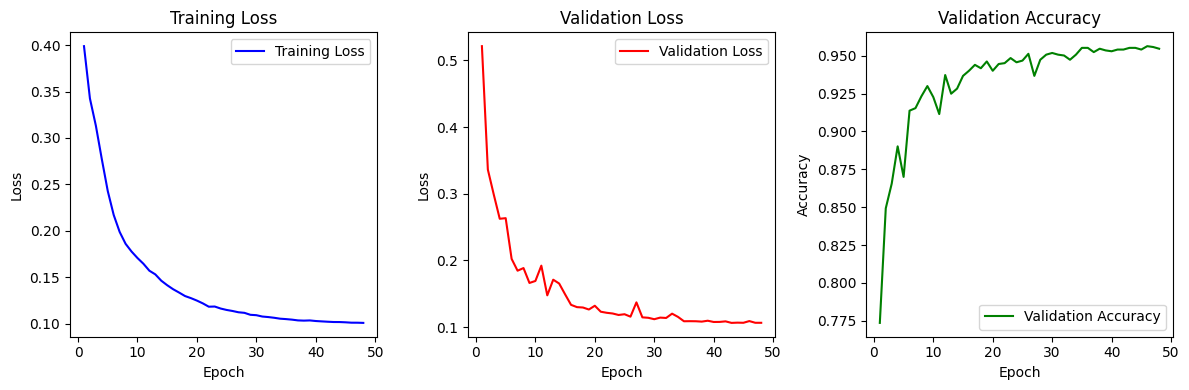

In [33]:
# Example usage:
plot_training_results(lstm_train_losses, lstm_val_losses, lstm_val_accuracies)

In [37]:
# Note: I run this on my local machine with RTX3060 so I have to clear cache each time

import gc
gc.collect()
torch.cuda.empty_cache()

print("Successfully clear the cache")

Successfully clear the cache


In [34]:
cnn_model = CNN_Model()

# Set up the loss function and optimizer
cnn_criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_epochs = 50  # Set number of epochs

cnn_model, cnn_train_losses, cnn_val_losses, cnn_val_accuracies = train_model(
        cnn_model, 
        criterion=cnn_criterion, 
        optimizer=cnn_optimizer, 
        epochs=cnn_epochs, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        scheduler=scheduler)
torch.save(cnn_model.state_dict(), "./model/cnn_model.pth")

Using device: cuda
Start training model: CNN_Model


Epoch [1/50]: 100%|██████████| 893/893 [00:04<00:00, 209.58it/s, loss=0.099] 


Epoch 1: Train Loss=0.2988, Val Loss=0.2204, Val Acc=0.9014


Epoch [2/50]: 100%|██████████| 893/893 [00:03<00:00, 240.06it/s, loss=0.33]  


Epoch 2: Train Loss=0.2103, Val Loss=0.1735, Val Acc=0.9221


Epoch [3/50]: 100%|██████████| 893/893 [00:03<00:00, 232.59it/s, loss=0.173]  


Epoch 3: Train Loss=0.1793, Val Loss=0.1833, Val Acc=0.9221


Epoch [4/50]: 100%|██████████| 893/893 [00:03<00:00, 263.44it/s, loss=0.733]  


Epoch 4: Train Loss=0.1664, Val Loss=0.1704, Val Acc=0.9339


Epoch [5/50]: 100%|██████████| 893/893 [00:03<00:00, 254.77it/s, loss=0.196]  


Epoch 5: Train Loss=0.1467, Val Loss=0.1145, Val Acc=0.9563


Epoch [6/50]: 100%|██████████| 893/893 [00:03<00:00, 270.59it/s, loss=0.062]  


Epoch 6: Train Loss=0.1347, Val Loss=0.1307, Val Acc=0.9513


Epoch [7/50]: 100%|██████████| 893/893 [00:03<00:00, 254.19it/s, loss=0.505]  


Epoch 7: Train Loss=0.1272, Val Loss=0.0970, Val Acc=0.9686


Epoch [8/50]: 100%|██████████| 893/893 [00:03<00:00, 259.20it/s, loss=0.00612]


Epoch 8: Train Loss=0.1251, Val Loss=0.1627, Val Acc=0.9350


Epoch [9/50]: 100%|██████████| 893/893 [00:03<00:00, 264.21it/s, loss=0.341]  


Epoch 9: Train Loss=0.1112, Val Loss=0.0927, Val Acc=0.9641


Epoch [10/50]: 100%|██████████| 893/893 [00:03<00:00, 257.86it/s, loss=0.0151] 


Epoch 10: Train Loss=0.1083, Val Loss=0.0832, Val Acc=0.9697


Epoch [11/50]: 100%|██████████| 893/893 [00:03<00:00, 253.81it/s, loss=0.247]  


Epoch 11: Train Loss=0.1006, Val Loss=0.0762, Val Acc=0.9804


Epoch [12/50]: 100%|██████████| 893/893 [00:03<00:00, 260.08it/s, loss=0.152]   


Epoch 12: Train Loss=0.0923, Val Loss=0.0966, Val Acc=0.9664


Epoch [13/50]: 100%|██████████| 893/893 [00:03<00:00, 259.22it/s, loss=0.0424]  


Epoch 13: Train Loss=0.0807, Val Loss=0.0617, Val Acc=0.9759


Epoch [14/50]: 100%|██████████| 893/893 [00:03<00:00, 258.32it/s, loss=0.167]   


Epoch 14: Train Loss=0.0783, Val Loss=0.0942, Val Acc=0.9619


Epoch [15/50]: 100%|██████████| 893/893 [00:03<00:00, 263.56it/s, loss=0.0498]  


Epoch 15: Train Loss=0.0757, Val Loss=0.0539, Val Acc=0.9798


Epoch [16/50]: 100%|██████████| 893/893 [00:03<00:00, 259.14it/s, loss=0.161]   


Epoch 16: Train Loss=0.0660, Val Loss=0.0986, Val Acc=0.9591


Epoch [17/50]: 100%|██████████| 893/893 [00:03<00:00, 251.84it/s, loss=0.0027]  


Epoch 17: Train Loss=0.0631, Val Loss=0.0446, Val Acc=0.9832


Epoch [18/50]: 100%|██████████| 893/893 [00:03<00:00, 233.70it/s, loss=0.459]   


Epoch 18: Train Loss=0.0577, Val Loss=0.0476, Val Acc=0.9849


Epoch [19/50]: 100%|██████████| 893/893 [00:03<00:00, 235.08it/s, loss=0.188]   


Epoch 19: Train Loss=0.0607, Val Loss=0.0374, Val Acc=0.9888


Epoch [20/50]: 100%|██████████| 893/893 [00:03<00:00, 225.36it/s, loss=0.174]   


Epoch 20: Train Loss=0.0536, Val Loss=0.0521, Val Acc=0.9826


Epoch [21/50]: 100%|██████████| 893/893 [00:03<00:00, 241.17it/s, loss=0.836]   


Epoch 21: Train Loss=0.0523, Val Loss=0.0419, Val Acc=0.9821


Epoch [22/50]: 100%|██████████| 893/893 [00:03<00:00, 228.90it/s, loss=0.000188]


Epoch 22: Train Loss=0.0449, Val Loss=0.0367, Val Acc=0.9849


Epoch [23/50]: 100%|██████████| 893/893 [00:03<00:00, 245.82it/s, loss=0.00164] 


Epoch 23: Train Loss=0.0427, Val Loss=0.0334, Val Acc=0.9877


Epoch [24/50]: 100%|██████████| 893/893 [00:04<00:00, 221.93it/s, loss=0.355]   


Epoch 24: Train Loss=0.0409, Val Loss=0.0305, Val Acc=0.9877


Epoch [25/50]: 100%|██████████| 893/893 [00:03<00:00, 237.42it/s, loss=0.133]   


Epoch 25: Train Loss=0.0395, Val Loss=0.0319, Val Acc=0.9877


Epoch [26/50]: 100%|██████████| 893/893 [00:03<00:00, 248.74it/s, loss=0.0157]  


Epoch 26: Train Loss=0.0362, Val Loss=0.0307, Val Acc=0.9877


Epoch [27/50]: 100%|██████████| 893/893 [00:03<00:00, 249.97it/s, loss=0.000167]


Epoch 27: Train Loss=0.0377, Val Loss=0.0294, Val Acc=0.9899


Epoch [28/50]: 100%|██████████| 893/893 [00:04<00:00, 214.59it/s, loss=0.000461]


Epoch 28: Train Loss=0.0316, Val Loss=0.0418, Val Acc=0.9843


Epoch [29/50]: 100%|██████████| 893/893 [00:03<00:00, 232.64it/s, loss=0.0322]  


Epoch 29: Train Loss=0.0333, Val Loss=0.0443, Val Acc=0.9843


Epoch [30/50]: 100%|██████████| 893/893 [00:03<00:00, 245.36it/s, loss=0.00361] 


Epoch 30: Train Loss=0.0324, Val Loss=0.0356, Val Acc=0.9871


Epoch [31/50]: 100%|██████████| 893/893 [00:04<00:00, 190.97it/s, loss=0.0277]  


Epoch 31: Train Loss=0.0299, Val Loss=0.0241, Val Acc=0.9916


Epoch [32/50]: 100%|██████████| 893/893 [00:03<00:00, 227.96it/s, loss=0.0239]  


Epoch 32: Train Loss=0.0289, Val Loss=0.0300, Val Acc=0.9882


Epoch [33/50]: 100%|██████████| 893/893 [00:03<00:00, 229.37it/s, loss=0.0195]  


Epoch 33: Train Loss=0.0282, Val Loss=0.0262, Val Acc=0.9894


Epoch [34/50]: 100%|██████████| 893/893 [00:03<00:00, 247.94it/s, loss=0.0453]  


Epoch 34: Train Loss=0.0266, Val Loss=0.0225, Val Acc=0.9938


Epoch [35/50]: 100%|██████████| 893/893 [00:04<00:00, 218.32it/s, loss=0.00203] 


Epoch 35: Train Loss=0.0275, Val Loss=0.0243, Val Acc=0.9905


Epoch [36/50]: 100%|██████████| 893/893 [00:04<00:00, 208.74it/s, loss=0.000176]


Epoch 36: Train Loss=0.0253, Val Loss=0.0273, Val Acc=0.9899


Epoch [37/50]: 100%|██████████| 893/893 [00:03<00:00, 233.28it/s, loss=0.000811]


Epoch 37: Train Loss=0.0266, Val Loss=0.0228, Val Acc=0.9933


Epoch [38/50]: 100%|██████████| 893/893 [00:03<00:00, 229.04it/s, loss=0.000976]


Epoch 38: Train Loss=0.0247, Val Loss=0.0234, Val Acc=0.9938


Epoch [39/50]: 100%|██████████| 893/893 [00:03<00:00, 238.13it/s, loss=0.00726] 


Epoch 39: Train Loss=0.0249, Val Loss=0.0215, Val Acc=0.9927


Epoch [40/50]: 100%|██████████| 893/893 [00:03<00:00, 240.48it/s, loss=0.0115]  


Epoch 40: Train Loss=0.0232, Val Loss=0.0200, Val Acc=0.9933


Epoch [41/50]: 100%|██████████| 893/893 [00:04<00:00, 216.28it/s, loss=0.0143]  


Epoch 41: Train Loss=0.0235, Val Loss=0.0219, Val Acc=0.9938


Epoch [42/50]: 100%|██████████| 893/893 [00:03<00:00, 252.89it/s, loss=0.0364]  


Epoch 42: Train Loss=0.0226, Val Loss=0.0217, Val Acc=0.9944


Epoch [43/50]: 100%|██████████| 893/893 [00:03<00:00, 244.96it/s, loss=0.000508]


Epoch 43: Train Loss=0.0229, Val Loss=0.0212, Val Acc=0.9927


Epoch [44/50]: 100%|██████████| 893/893 [00:03<00:00, 249.46it/s, loss=0.116]   


Epoch 44: Train Loss=0.0229, Val Loss=0.0197, Val Acc=0.9944


Epoch [45/50]: 100%|██████████| 893/893 [00:03<00:00, 267.63it/s, loss=0.00475] 


Epoch 45: Train Loss=0.0222, Val Loss=0.0216, Val Acc=0.9910


Epoch [46/50]: 100%|██████████| 893/893 [00:03<00:00, 271.09it/s, loss=0.021]   


Epoch 46: Train Loss=0.0217, Val Loss=0.0210, Val Acc=0.9933


Epoch [47/50]: 100%|██████████| 893/893 [00:03<00:00, 260.19it/s, loss=0.0106]  


Epoch 47: Train Loss=0.0211, Val Loss=0.0206, Val Acc=0.9938


Epoch [48/50]: 100%|██████████| 893/893 [00:03<00:00, 259.99it/s, loss=0.00439] 


Epoch 48: Train Loss=0.0229, Val Loss=0.0198, Val Acc=0.9944


Epoch [49/50]: 100%|██████████| 893/893 [00:03<00:00, 269.71it/s, loss=0.00267] 


Epoch 49: Train Loss=0.0200, Val Loss=0.0204, Val Acc=0.9938
Early stopping triggered after 49 epochs
Finish training model: CNN_Model


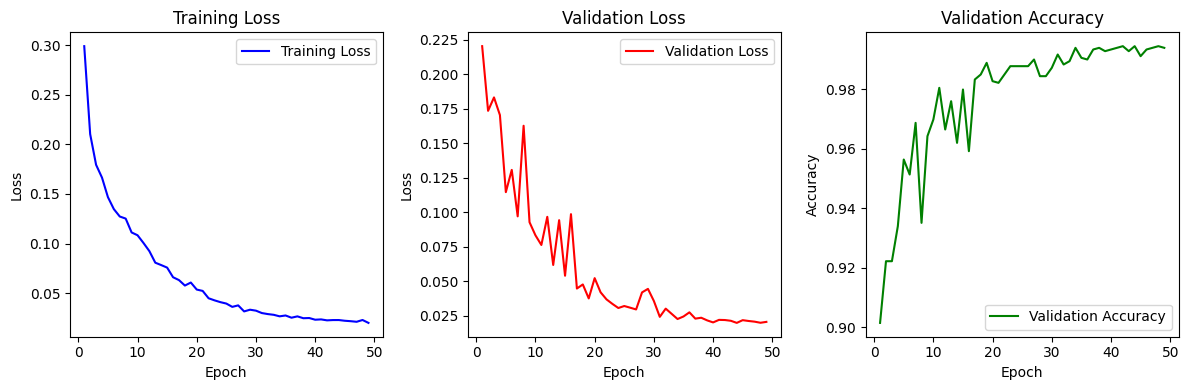

In [35]:
# Example usage:
plot_training_results(cnn_train_losses, cnn_val_losses, cnn_val_accuracies)

In [36]:
def perform_model_on_test_dataset(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()  # Assuming sigmoid output, convert to 0 or 1
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Model Test Accuracy: {accuracy * 100:.2f}%')

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model parameters
input_size = 51   # Number of features (e.g., in your falling data)
hidden_size = 16  # Number of units in the hidden state
num_layers = 1    # Number of LSTM layers (you can experiment with this)
dropout = 0.5     # Dropout rate for regularization

# Initialize the LSTM_Model model
lstm_model = LSTM_Model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
lstm_model.load_state_dict(torch.load('./model/lstm_model.pth'))

# Set the model to evaluation mode (important for inference)
lstm_model.eval()
lstm_model.to(device)

# Example usage:
perform_model_on_test_dataset(lstm_model, test_loader, device)

Model Test Accuracy: 95.57%


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_model = CNN_Model()
cnn_model.load_state_dict(torch.load('./model/cnn_model.pth'))

# Set the model to evaluation mode (important for inference)
cnn_model.eval()
cnn_model.to(device)

# Example usage:
perform_model_on_test_dataset(cnn_model, test_loader, device)

Model Test Accuracy: 99.27%


In [46]:
rule_total = 0
rule_correct = 0

print(len(all_data[0]))
print(len(all_data))

for row in all_data:
    label = int(row[0])  # ground truth
    xmin, ymin, xmax, ymax = row[1:5]
    flatten_pose = row[5:]  # keypoints + confidences

    prediction, _ = rule_fall_detection(flatten_pose, xmin, ymin, xmax, ymax)
    pred_label = int(prediction)  # Convert True/False to 1/0

    if pred_label == label:
        rule_correct += 1
    rule_total += 1

rule_accuracy = rule_correct / rule_total if rule_total > 0 else 0
print(f"Rule-based model accuracy: {rule_accuracy:.2%}")

56
17850
Rule-based model accuracy: 72.20%
